## <center> Predicting airbnb apartment prices using OLS, LASSO and Random Forest. <br/> Case study of Madrid city apartments. </center>

In [81]:
!pip install geopy

In [188]:
import os
import sys
import warnings
from pathlib import Path

import gzip
import csv
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mizani.formatters import percent_format
from patsy import dmatrices
from plotnine import *
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import (
    partial_dependence,
    permutation_importance,
    plot_partial_dependence,
)
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from datetime import datetime
import re
import geopy.distance

warnings.filterwarnings("ignore")

In [189]:
#Read the dataset
data = pd.read_csv('listings.csv.gz', compression='gzip',
                   error_bad_lines=False)
#Get all column names and general info about the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20776 entries, 0 to 20775
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            20776 non-null  int64  
 1   listing_url                                   20776 non-null  object 
 2   scrape_id                                     20776 non-null  int64  
 3   last_scraped                                  20776 non-null  object 
 4   source                                        20776 non-null  object 
 5   name                                          20772 non-null  object 
 6   description                                   20117 non-null  object 
 7   neighborhood_overview                         11429 non-null  object 
 8   picture_url                                   20775 non-null  object 
 9   host_id                                       20776 non-null 

## Data cleaning and preparation

In [190]:
#Drop the observations where price information is NaN

data = data.loc[data.price.notna(), :]

In [191]:
#A function to count the remaining missing values

def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]

In [192]:
count_missing_values(data)

name                               4
description                      659
neighborhood_overview           9347
picture_url                        1
host_name                          3
host_since                         3
host_location                   5462
host_about                     10637
host_response_time              4649
host_response_rate              4649
host_acceptance_rate            4236
host_is_superhost                  6
host_thumbnail_url                 3
host_picture_url                   3
host_neighbourhood             10397
host_listings_count                3
host_total_listings_count          3
host_has_profile_pic               3
host_identity_verified             3
neighbourhood                   9347
bathrooms                      20776
bathrooms_text                    21
bedrooms                        1516
beds                             305
minimum_minimum_nights             5
maximum_minimum_nights             5
minimum_maximum_nights             5
m

In [193]:
#I will double-check that accommodates column indicates number of guests that can be accommodated.
data['accommodates'].head(10)

0    2
1    1
2    3
3    2
4    8
5    1
6    3
7    2
8    3
9    3
Name: accommodates, dtype: int64

In [194]:
#The task requires to analyze mid-size apartments, i.e. for 2-6 guests. So, I will filter the dataset accordingly.

data = data[(data["accommodates"] < 7) & (data["accommodates"] > 1)]

In [195]:
# copy a variable - purpose later, see at variable importance
data = data.assign(accommodates_copy=data.accommodates)

In [196]:
#Check price distribution

data['price'].describe()

count      16620
unique       606
top       $50.00
freq         314
Name: price, dtype: object

In [197]:
#See the share of different room types in the data

data.room_type.value_counts()

Entire home/apt    12231
Private room        4174
Shared room          110
Hotel room           105
Name: room_type, dtype: int64

In [198]:
#Property type share
data.property_type.value_counts()

Entire rental unit             10054
Private room in rental unit     2895
Entire condo                     734
Entire loft                      709
Private room in home             337
                               ...  
Shared room in hut                 1
Entire bungalow                    1
Hut                                1
Dome                               1
Bus                                1
Name: property_type, Length: 61, dtype: int64

In [199]:
#Check what type of properties exist
data['property_type'].unique()

array(['Private room in rental unit', 'Entire rental unit', 'Entire loft',
       'Entire condo', 'Shared room in rental unit',
       'Private room in chalet', 'Entire home',
       'Entire serviced apartment', 'Private room in home',
       'Shared room in hut', 'Private room in bed and breakfast',
       'Entire bungalow', 'Shared room in bed and breakfast',
       'Casa particular', 'Private room in floor', 'Entire vacation home',
       'Dome', 'Entire place', 'Private room in condo',
       'Private room in guest suite', 'Private room',
       'Shared room in home', 'Private room in serviced apartment',
       'Room in serviced apartment', 'Private room in loft',
       'Entire guesthouse', 'Room in aparthotel',
       'Private room in guesthouse', 'Floor', 'Room in hotel',
       'Private room in townhouse', 'Room in boutique hotel',
       'Entire townhouse', 'Private room in hostel',
       'Shared room in loft', 'Hut', 'Entire guest suite',
       'Private room in casa partic

In [200]:
#I will filter the data again to keep only entire rental units, entire condo, entire loft
#and drop other accommodation types because our analysis should include only apartments

data = data[data['property_type'].isin(['Entire rental unit', 'Entire condo', 'Entire loft'])]

In [201]:
# drop the lines where id is not a number
data.id = pd.to_numeric(data.id, errors="coerce")
data = data[data.id.notna()]

In [202]:
#Decide which variable to use for location
#data['neighbourhood'].unique()
#data['neighbourhood_group'].unique()

data['neighbourhood_group_cleansed'].unique()

array(['Centro', 'Salamanca', 'Fuencarral - El Pardo', 'Villaverde',
       'Chamberí', 'Hortaleza', 'Puente de Vallecas', 'Retiro',
       'Ciudad Lineal', 'Arganzuela', 'Moncloa - Aravaca',
       'San Blas - Canillejas', 'Chamartín', 'Carabanchel', 'Tetuán',
       'Vicálvaro', 'Latina', 'Moratalaz', 'Villa de Vallecas', 'Usera',
       'Barajas'], dtype=object)

After checking the neighbourhood variables, it is obvious that neighbourhood_group_cleansed is the most relevant because it groups the major sites in the city that are located close to each other. 

In [203]:
# Format binary variables
for binary in [
    "host_is_superhost",
    "instant_bookable",
]:
    data[binary] = data[binary].map({"t": True, "f": False})

In [206]:
# Clean the price column
data["price"] = data["price"].astype(str)
data["price"] = data.price.str.replace("\\$", "").str.replace(",","").astype(float)

In [208]:
# Clean amenities column

data["amenities"] = data["amenities"].astype(str)
data["amenities"] = (
    data["amenities"]
    .str.strip("{}")
    .str.replace('"', "")
    .str.replace("[", "")
    .str.replace("]", "")
    .str.replace("–", "")
    .str.replace("-", "")
    .str.replace("\\u", "'", regex=False)
    .str.replace("\d", "", regex=True)
    .str.replace("'", "")
    .str.lower()
    .str.replace("mbps", "",regex=False)
    .str.strip()
    .str.split(",")
)

In [209]:
# Create dummies by amenities
data["amenities"].explode().str.strip().value_counts()

kitchen                                      11154
long term stays allowed                      10650
wifi                                         10603
essentials                                   10237
hair dryer                                    9294
                                             ...  
tv with apple tv                                 1
.  body soap                                     1
.  refrigerator                                  1
asi como gel cdntimo y champues body soap        1
marca de carrefour  body soap                    1
Name: amenities, Length: 1087, dtype: int64

In [210]:
# Keep those, that has 50 or more count
amenities_keep = data["amenities"].explode().str.strip().value_counts().loc[lambda x: x>50]

amenities_keep.to_pickle("amenities_to_keep.pkl")

In [211]:
pd.get_dummies(data.amenities.apply(pd.Series).stack().str.strip())

% body soap  (contiene alimentos nuestros  .  body soap  \
2     0   0            0                             0             0   
      1   0            0                             0             0   
      2   0            0                             0             0   
      3   0            0                             0             0   
      4   0            0                             0             0   
...      ..          ...                           ...           ...   
20775 22  0            0                             0             0   
      23  0            0                             0             0   
      24  0            0                             0             0   
      25  0            0                             0             0   
      26  0            0                             0             0   

          .  refrigerator  . body soap  . refrigerator  . shampoo  \
2     0                 0            0               0          0   
      1                 0            0               0          0   
      2                 0            0               0          0   
      3                 0            0               0          0   
      4                 0            0               0          0   
...                   ...          ...             ...        ...   
20775 22                0            0               0          0   
      23                0            0               0          0   
      24                0            0               0          0   
      25                0            0               0          0   
      26                0            0               0          0   

          . stainless steel oven  ... refrigerator  ...  zambu body soap  \
2     0                        0                 0  ...                0   
      1                        0                 0  ...                0   
      2                        0                 0  ...                0   
      3                        0                 0  ...                0   
      4                        0                 0  ...                0   
...                          ...               ...  ...              ...   
20775 22                       0                 0  ...                0   
      23                       0                 0  ...                0   
      24                       0                 0  ...                0   
      25                       0                 0  ...                0   
      26                       0                 0  ...                0   

          zanussi electric stove  zanussi oven  zanussi refrigerator  \
2     0                        0             0                     0   
      1                        0             0                     0   
      2                        0             0                     0   
      3                        0             0                     0   
      4                        0             0                     0   
...                          ...           ...                   ...   
20775 22                       0             0                     0   
      23                       0             0                     0   
      24                       0             0                     0   
      25                       0             0                     0   
      26                       0             0                     0   

          zara home  zara home  white jasmine hand & body body soap  \
2     0           0                                               0   
      1           0                                               0   
      2           0                                               0   
      3           0                                               0   
      4           0                                               0   
...             ...                                             ...   
20775 22          0                         

In [212]:
dummies = pd.get_dummies(data.amenities.apply(pd.Series).stack().str.strip()).sum(level=0)
data = pd.concat([data, dummies], axis=1)

In [213]:
#Replace the amenities column with dummies column
drops = ["amenities"]
data.drop(columns=drops, inplace=True)

In [214]:
data["neighbourhood_group_cleansed"].value_counts().loc[lambda x: x<50]

Barajas              41
Villa de Vallecas    31
Moratalaz            26
Vicálvaro            16
Name: neighbourhood_group_cleansed, dtype: int64

In [215]:
#Group the neighbourhoods that have less than 50 observations as Others

data["neighbourhood_group_cleansed"] = np.where(
    data["neighbourhood_group_cleansed"].isin(
        data["neighbourhood_group_cleansed"]
        .value_counts()
        .loc[lambda x: x < 50]
        .index.tolist()
    ),
    "Other",
    data["neighbourhood_group_cleansed"],
)

In [216]:
# Neighbourhood_group_cleansed as location

data["f_location"] = data["neighbourhood_group_cleansed"].astype("category")

In [217]:
data["f_location"].value_counts()

Centro                   6000
Salamanca                1009
Chamberí                  692
Arganzuela                592
Tetuán                    537
Retiro                    414
Chamartín                 360
Carabanchel               297
Moncloa - Aravaca         242
Ciudad Lineal             225
Puente de Vallecas        219
Latina                    173
Hortaleza                 169
Usera                     153
San Blas - Canillejas     139
Other                     114
Fuencarral - El Pardo     102
Villaverde                 60
Name: f_location, dtype: int64

In [218]:
#See bathroom types
data.bathrooms_text.value_counts()

1 bath       8629
2 baths      1904
1.5 baths     660
3 baths       143
2.5 baths     118
0 baths        15
3.5 baths      13
Half-bath       5
4 baths         4
4.5 baths       3
10 baths        1
5 baths         1
Name: bathrooms_text, dtype: int64

In [219]:
data.bathrooms_text = np.where(data.bathrooms_text == "Half-bath", "0.5 baths",data.bathrooms_text)

In [220]:
data["n_bathrooms"] = data.bathrooms_text.str.split().str[0].apply(float)

In [221]:
data["n_bathrooms"].value_counts(dropna=False).sort_index()

0.0       15
0.5        5
1.0     8629
1.5      660
2.0     1904
2.5      118
3.0      143
3.5       13
4.0        4
4.5        3
5.0        1
10.0       1
NaN        1
Name: n_bathrooms, dtype: int64

In [222]:
#Fill nan value with median in order not to lose data point
data["n_bathrooms"] = data["n_bathrooms"].fillna(data["n_bathrooms"].median())

In [223]:
#Add numerical columns from existing ones

numericals = [
    "accommodates",
    "review_scores_rating",
    "number_of_reviews",
    "availability_365",
    "minimum_nights",
    "beds",
    'maximum_nights',
    
]

for col in numericals:
    data["n_" + col] = pd.to_numeric(data[col], errors="coerce")

In [224]:
# Create days since first review

data["n_days_since"] = (
    data.calendar_last_scraped.apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
    - data.first_review.fillna("1950-01-01").apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d")
    )
).dt.days

data["n_days_since"] = np.where(data.first_review.isnull(), np.nan, data.n_days_since)

In [225]:
amenities_to_keep = pd.read_pickle("amenities_to_keep.pkl")

In [226]:
# create dummy variables for amenities
dummies = amenities_to_keep.index.tolist()

for col in dummies:
    data["d_" + (re.sub("/|\s|-", "", col)).replace("(s)", "s").lower()] = data[col]

In [227]:
#Create distance variable to show distance from the center. 
#In the centre of the Centro is Plaza Mayor, so I will take its location as baseline.

distances = []
for accom_coord in np.array(data[['latitude', 'longitude']]):
    coords_plaza_mayor = (40.415524, -3.707488)
    # this function calculates distance of coordinates (in km)
    distances.append(geopy.distance.distance(coords_plaza_mayor, accom_coord).km)

In [228]:
data["n_dist_to_plaza_mayor"] = distances

<AxesSubplot: >

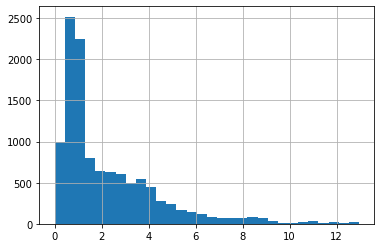

In [229]:
data.n_dist_to_plaza_mayor.hist(bins=30)

As we can see, majority of the apartments are close to the centre, so it will be important to consider location to beat the competitors.

In [230]:
drops=[
     "beds",
    "bathrooms",
    "review_scores_rating",
]
data.drop(columns=drops, inplace=True)

### Prepare dataset for lasso

In [231]:
# Squares and further values to create
data = data.assign(
    accommodates2=lambda x: x["n_accommodates"] ** 2,
    dist_to_plaza_mayor2=lambda x: x["n_dist_to_plaza_mayor"] ** 2,
    ln_accommodates=lambda x: np.log(x["n_accommodates"]),
    ln_accommodates2=lambda x: np.log(x["n_accommodates"]) ** 2,
    ln_beds=lambda x: np.log(x["n_beds"]),
    ln_number_of_reviews=lambda x: np.log(x["n_number_of_reviews"] + 1),
)

In [232]:
# Pool num of reviews to 3 categories: none, 1-51 and >51

bins = pd.IntervalIndex.from_tuples(
    [(0, 1), (1, 51), (51, max(data.n_number_of_reviews))], closed="left"
)
fnor = pd.cut(data["n_number_of_reviews"].to_list(), bins, labels=["0", "1", "2"])
fnor.categories = [0, 1, 2]
data["f_number_of_reviews"] = fnor
data["f_number_of_reviews"].value_counts(dropna=False)

1      6358
2      3274
0      1864
NaN       1
Name: f_number_of_reviews, dtype: int64

In [233]:
# Pool and categorize the number of minimum nights: 1,2,3, 3+

bins = pd.IntervalIndex.from_tuples(
    [(1, 2), (2, 3), (3, max(data.n_minimum_nights))], closed="left"
)
f_min_n = pd.cut(data["n_minimum_nights"].to_list(), bins, labels=["1", "2", "3"])
f_min_n.categories = [1, 2, 3]
data["f_minimum_nights"] = f_min_n
data["f_minimum_nights"].value_counts(dropna=False)

3      5175
1      3444
2      2877
NaN       1
Name: f_minimum_nights, dtype: int64

In [234]:
# Change Infinite values with NaNs
data = data.replace([np.inf, -np.inf], np.nan)

In [235]:
# where do we have missing variables now?
to_filter = data.isna().sum()
to_filter[to_filter > 0]

name                               3
description                      236
neighborhood_overview           4787
host_name                          2
host_since                         2
host_location                   3109
host_about                      5638
host_response_time              1865
host_response_rate              1865
host_acceptance_rate            1641
host_thumbnail_url                 2
host_picture_url                   2
host_neighbourhood              5362
host_listings_count                2
host_total_listings_count          2
host_has_profile_pic               2
host_identity_verified             2
neighbourhood                   4787
bathrooms_text                     1
bedrooms                        1162
minimum_minimum_nights             5
maximum_minimum_nights             5
minimum_maximum_nights             5
maximum_maximum_nights             5
minimum_nights_avg_ntm             5
maximum_nights_avg_ntm             5
calendar_updated               11497
f

In [236]:
data.price.isnull().sum()

0

In [237]:
# Impute when few, not that important
data = data.assign(
    n_beds=lambda x: np.where(x["n_beds"].isnull(), x["n_accommodates"], x["n_beds"]),
    f_minimum_nights=lambda x: x["f_minimum_nights"].fillna(1),
    f_number_of_reviews=lambda x: x["f_number_of_reviews"].fillna(1),
    ln_beds=lambda x: x["ln_beds"].fillna(0),
    
)

In [239]:
# Replace missing variables re reviews with zero, when no review + add flags
data = data.assign(
    flag_days_since=np.multiply(data.n_days_since.isna(), 1),
    n_days_since=data.n_days_since.fillna(np.median(data.n_days_since.dropna())),
    flag_review_scores_rating=np.multiply(data.n_review_scores_rating.isna(), 1),
    n_review_scores_rating=data.n_review_scores_rating.fillna(
        np.median(data.n_review_scores_rating.dropna())
    ),
    flag_n_number_of_reviews=np.multiply(data.n_number_of_reviews.isna(), 1),
)

In [240]:
data.flag_days_since.value_counts()

0    9633
1    1864
Name: flag_days_since, dtype: int64

In [241]:
# Create variables, measuring the time since: squared, cubic, logs
data = data.assign(
    ln_days_since=lambda x: np.log(x["n_days_since"] + 1),
    ln_days_since2=lambda x: np.log(x["n_days_since"] + 1) ** 2,
    ln_days_since3=lambda x: np.log(x["n_days_since"] + 1) ** 3,
    n_days_since2=lambda x: x["n_days_since"] ** 2,
    n_days_since3=lambda x: x["n_days_since"] ** 3,
    ln_review_scores_rating=lambda x: np.log(x["n_review_scores_rating"]),
)

In [242]:
data.ln_days_since = data["ln_days_since"].fillna(0)
data.ln_days_since2 = data["ln_days_since2"].fillna(0)
data.ln_days_since3 = data["ln_days_since3"].fillna(0)

In [243]:
drops=[
     "host_listings_count",
    "first_review",
    "last_review",
]
data.drop(columns=drops, inplace=True)

In [244]:
to_filter = data.isna().sum()
to_filter[to_filter > 0]

name                               3
description                      236
neighborhood_overview           4787
host_name                          2
host_since                         2
host_location                   3109
host_about                      5638
host_response_time              1865
host_response_rate              1865
host_acceptance_rate            1641
host_thumbnail_url                 2
host_picture_url                   2
host_neighbourhood              5362
host_total_listings_count          2
host_has_profile_pic               2
host_identity_verified             2
neighbourhood                   4787
bathrooms_text                     1
bedrooms                        1162
minimum_minimum_nights             5
maximum_minimum_nights             5
minimum_maximum_nights             5
maximum_maximum_nights             5
minimum_nights_avg_ntm             5
maximum_nights_avg_ntm             5
calendar_updated               11497
review_scores_accuracy          1918
r

In [245]:
data["f_property_type"] = data["property_type"].astype("category")

In [246]:
# keep columns if contain d_, n_,f_, p_, usd_ and some others

data = data.filter(regex="^d_.*|^n_.*|^f_.*|^p_.*|^price.*").assign(id = data.id)

In [247]:
#Save the clean data for further analysis
data.to_csv("airbnb_madrid_workfile.csv", index=False)

The analysis will be performed in another notebook.